In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
import pandas as pd
from pyMRI.utils import RMSE

In [3]:
rerun = False
filename_end = ""
folder_name = "files/"

In [4]:
metabolites = pymri.METABOLITES

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
spins_phi = np.zeros_like(M_0s)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")


All frequencies are captured by the sampling rate.


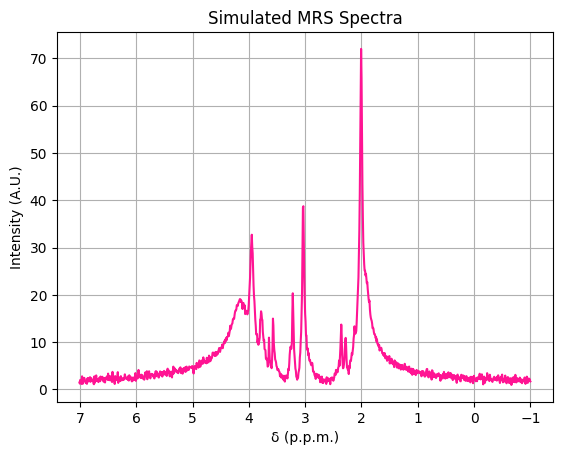

In [5]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )

c_sig = pymri.corrupted_snr(sig, 0.0, 0.01)
c_freqs, c_sig_fft = pymri.fourier_spectrum( c_sig, dt, B0 )

pymri.plot_chem_shifts( freqs, c_sig_fft, 1.0 )

In [6]:
L = np.arange(start = 0.2, stop = 0.8, step = 0.05)
noise_threshold = 1e-15
print(L)

[0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8 ]


In [7]:
reconstructed_sig, z, r = pymri.filter_sig( c_sig, 0.45, noise_threshold, rcond=rcond, zero_filtering=zero_filtering, return_poles_and_res=True )

In [8]:
s0, phi, omega, alpha = pymri.calculate_variables_from_z_and_r(z, r, dt)

# s0, phi, omega, gen_t2 = np.sort(s0), np.sort(phi), np.sort(omega), np.sort(1/alpha)
# M_0s, spins_phi, ws, t2s = np.sort(M_0s), np.sort(spins_phi), np.sort(ws), np.sort(t2s)

In [9]:
print(np.sort(omega))
print(ws)

[-6410.20719623 -6397.57495889 -6380.65910576 -6366.74114922
 -6352.98671628 -6335.25903357 -6325.64056521 -6322.65663799
 -6311.62990832 -6293.93644612 -6284.57312724 -6272.96798399
 -6254.84012591 -6238.21564364 -6228.37269733 -6214.51397679
 -6199.22828509 -6173.98418122 -6160.33070732 -6148.55845799
 -6137.83059363 -6115.957389   -6105.14923109 -6093.55737301
 -6070.5503946  -6068.02345521 -6052.1220558  -6032.94675349
 -6023.43640663 -6012.82311556 -5990.66010763 -5989.61748961
 -5973.39767999 -5950.68672196 -5944.01054391 -5928.78052722
 -5909.5142458  -5896.76420888 -5881.68258547 -5864.30038136
 -5853.71587294 -5834.9385376  -5824.27468575 -5812.03185468
 -5793.83199568 -5788.40133631 -5768.62399374 -5753.07950527
 -5738.9797867  -5725.30086598 -5706.06008485 -5699.04127879
 -5691.44032065 -5666.62854843 -5653.19214308 -5647.48150794
 -5630.21673962 -5613.85508408 -5597.11306336 -5582.6025699
 -5568.46778725 -5564.80034258 -5551.35535674 -5539.30097697
 -5518.688298   -5501.688

In [10]:
# 1. NÃO ordenar a lista individualmente para preservar as posições de cada parâmetro
# 2. Criar um parâmtero \Delta que define o tamanho máximo do raio de filtragem ao redor das frequências de referência de um sinal limpo
# 3. Filtrar as frequências ao redor dessa frequencia central dentro desse raio máximo
Delta = 50

In [11]:
mask = np.full_like(omega, False, dtype=bool)

for i in range(ws.size):
    mask = np.bitwise_or(mask, np.bitwise_and(omega > ws[i] - Delta, omega <= ws[i] + Delta)) 

In [12]:
filtered_s0 = s0[mask]
filtered_phi = phi[mask]
filtered_omega = omega[mask]
filtered_alpha = alpha[mask]

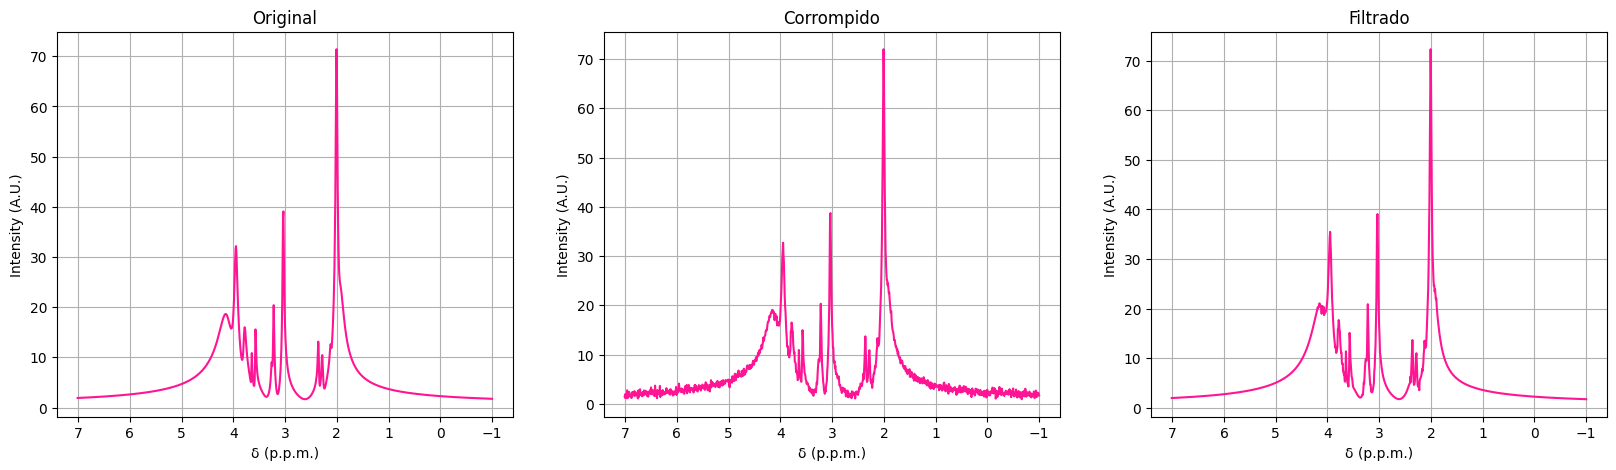

In [13]:
filtered_pop = pymri.population(filtered_omega, 1/filtered_alpha, filtered_s0, filtered_phi)

filtered_sig, t = pymri.population_transverse_decay(t0, tn, dt, filtered_pop, np.ndarray([]))

filtered_freqs, filtered_sig_fft = pymri.fourier_spectrum( filtered_sig, dt, B0 )

r_freqs, r_sig_fft = pymri.fourier_spectrum( reconstructed_sig, dt, B0 )

plt.figure(figsize = (20, 5))
plt.subplot(131)
pymri.plot_chem_shifts( freqs, sig_fft, 1.0, title="Original" )

plt.subplot(132)
pymri.plot_chem_shifts( c_freqs, c_sig_fft, 1.0, title="Corrompido" )

plt.subplot(133)
pymri.plot_chem_shifts( filtered_freqs, filtered_sig_fft, 1.0, title="Filtrado" )